In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Задание 1

# Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [2]:
# Надеюсь, будет работать :)

df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')

In [3]:
df_auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [4]:
# Перевел даты в рабочий формат

df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.date

In [5]:
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date

In [6]:
# Добавил рандомную колонку для проверки - не записывается ли то, что пользователь заходил несколько раз за день (стоит учитывать при построении формулы в будущем)  

df_auth['auth'] = df_auth.uid

In [7]:
# Как видно, такие данные отсутствуют, колонку можно удалять

df_auth \
    .groupby(['uid', 'auth_ts'], as_index=False) \
    .agg({'auth': 'count'}) \
    .sort_values('auth', ascending=False)

,uid,auth_ts,auth
0,1,1998-11-18,1
6400688,416581,2020-07-04,1
6400672,416581,2020-05-12,1
6400673,416581,2020-05-13,1
6400674,416581,2020-05-16,1
...,...,...,...
3200338,141058,2018-12-13,1
3200339,141058,2018-12-19,1
3200340,141058,2018-12-26,1
3200341,141058,2018-12-28,1


In [8]:
df_auth = df_auth.drop(columns='auth')

In [9]:
# Добавляю дату регистрации (называю "когортой") 

df_auth = df_auth.merge(df_reg[['uid', 'reg_ts']], how='inner', on='uid').rename(columns={'reg_ts': 'cohort', 'auth_ts': 'authorization'})

In [10]:
df_auth.head()

,authorization,uid,cohort
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [11]:
df_cohort = df_auth \
    .groupby(['cohort', 'authorization']) \
    .agg(n_users=('uid', 'nunique')) \
    .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.authorization - df_cohort.cohort).dt.days

In [12]:
# Поскольку у нас задача проанализировать retention по дням, а база данных за 5110 дней + по заданию можно взять сэмпл - 
# беру в анализ тот месяц, где было больше всего регистраций.

df_cohort.cohort.describe()

count        2716228
unique          5110
top       2013-10-31
freq            2079
Name: cohort, dtype: object

In [13]:
# Для его определения создам отдельные две колонки

df_cohort['year'] = pd.to_datetime(df_cohort.cohort).dt.year
df_cohort['month'] = pd.to_datetime(df_cohort.cohort).dt.month

In [14]:
df_cohort.loc[df_cohort['period_number'] == 0] \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'n_users': 'sum'}) \
    .sort_values('n_users', ascending=False)

# Беру в сэмпл когорту 2020-08, анализирую 1 месяц (31 день).

,year,month,n_users
233,2020,8,47882
232,2020,7,45502
231,2020,6,41880
230,2020,5,41159
229,2020,4,37884
...,...,...,...
22,2003,1,1
24,2003,3,1
25,2003,4,1
27,2003,6,1


In [15]:
# По сути - здесь мы можем настраивать выборку и период для анализа. Оставляю уже выбранную и только месяц август 2020 года

df_sample = df_cohort.loc[(df_cohort['year'] == 2020) & (df_cohort['month'] == 8) & (df_cohort['period_number'] <= 31) & (pd.to_datetime(df_cohort['authorization']) <= '2020-08-31')]

In [16]:
# Данные с когортами

cohort_pivot = df_sample.pivot_table(index = 'cohort', columns = 'period_number', values = 'n_users')

In [17]:
# Перевожу в процентое соотношение к нулевому дню (дню формирования когорты) и считаю для каждого периода (дня)

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

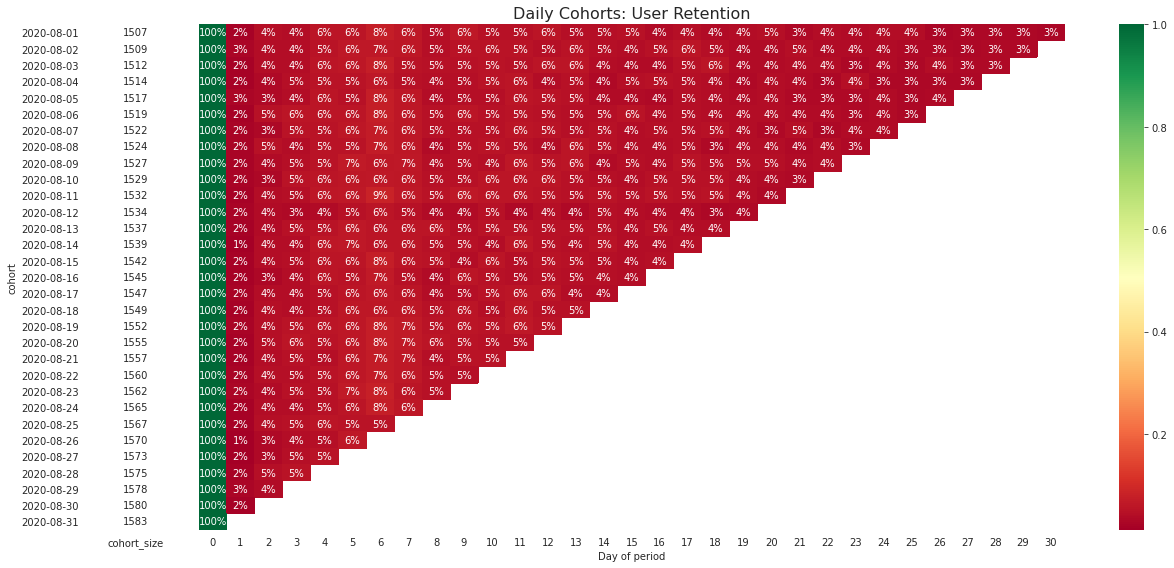

In [18]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Daily Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='Day of period',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

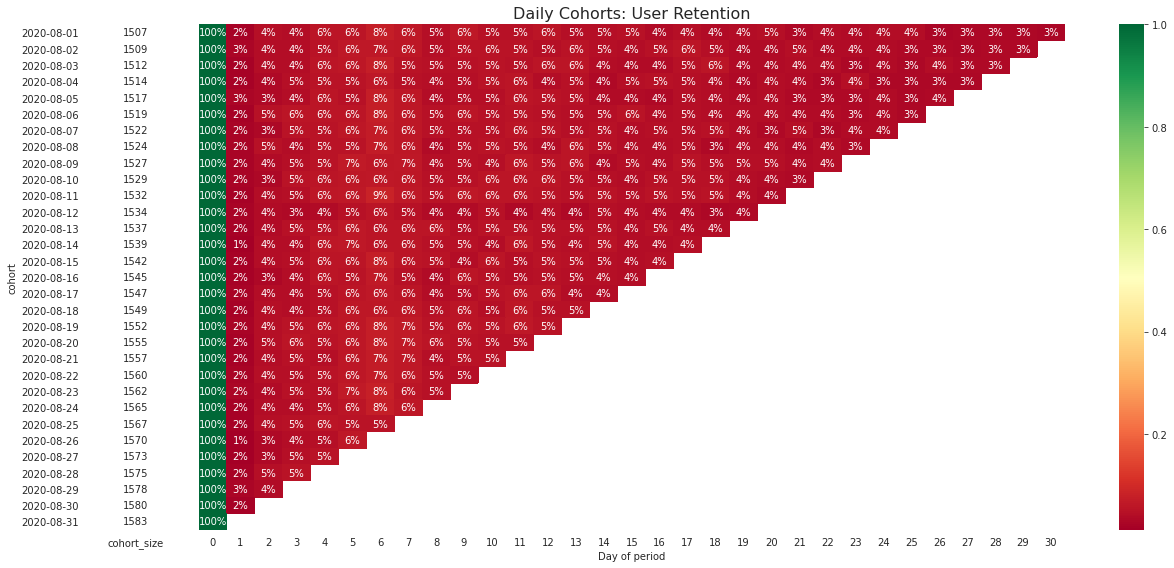

In [6]:
# Функция для определения retention

def cohort_analysis (df_auth, df_reg):
    df_auth = df_auth.merge(df_reg[['uid', 'reg_ts']], how='inner', on='uid') \
        .rename(columns={'reg_ts': 'cohort', 'auth_ts': 'authorization'})
    df_cohort = df_auth \
        .groupby(['cohort', 'authorization']) \
        .agg(n_users=('uid', 'nunique')) \
        .reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.authorization - df_cohort.cohort).dt.days
    df_cohort['year'] = pd.to_datetime(df_cohort.cohort).dt.year
    df_cohort['month'] = pd.to_datetime(df_cohort.cohort).dt.month
    df_sample = df_cohort.loc[(df_cohort['year'] == 2020) & (df_cohort['month'] == 8) & (df_cohort['period_number'] <= 31) & 
                              (pd.to_datetime(df_cohort['authorization']) <= '2020-08-31')]
    cohort_pivot = df_sample.pivot_table(index = 'cohort', columns = 'period_number', values = 'n_users')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    # Визуал
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title('Daily Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='Day of period',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()
        
cohort_analysis(df_auth, df_reg)

# Выше был приведен порядок подсчета Retention в сэмпле с дневными когортами за август 2020, анализирую поведение в августе (31 день). Также вынесена отдельно функция (согласно задания), в которую "завернут" тот же порядок. Оставил ее в конце, так как комментарии и минимальный EDA, который проводил перед ее написанием, не входят в саму функцию (для удобства чтения), но имеют значение для понимания логики ее построения. Фильтр по когортам и исследуемому периоду в функции  - переменная df_sample. Чтоб проверить отдельно функцию - нужно запустить ее после строки 5 (то есть после перевода дат из Unix в рабочий формат).

# Задание 2

# Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [12]:
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import numpy as np

In [21]:
df_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/12gk_ATEeBZm4A', sep=';')

In [22]:
# Для начала - ознакомлюсь с данными и условиями

revenue = df_2 \
    .groupby('testgroup', as_index=False) \
    .agg({'revenue': 'sum'})
revenue

,testgroup,revenue
0,a,5136189
1,b,5421603


In [23]:
all_users = df_2 \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique'})
all_users

,testgroup,user_id
0,a,202103
1,b,202667


In [24]:
paid_users = df_2.query('revenue > 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique'})
paid_users

,testgroup,user_id
0,a,1928
1,b,1805


In [24]:
ARPU = revenue.revenue / all_users.user_id

In [25]:
# ARPU у тестовой группы действительно выше на 5%, чем у контрольной

ARPU[1] / ARPU[0]

1.052631683600699

In [26]:
df_2

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [27]:
# Для начала, проверю нормальность распределения у обоих групп. Сокращу до 5000 рандомных выборок (по Шапиро)

sample_a = df_2.loc[df_2['testgroup'] == 'a'].sample(5000)
sample_b = df_2.loc[df_2['testgroup'] == 'b'].sample(5000)

In [28]:
stats.shapiro(x=sample_a.revenue)

ShapiroResult(statistic=0.009159684181213379, pvalue=0.0)

In [29]:
# Как мы видим, данные в обоих группах далеки от нормального распределения. Также дополнительно проверил только тех пользователей, 
# у которых revenue > 0, однако там та же история (решил не прикреплять здесь). Распределения не являются нормальными.

stats.shapiro(x=sample_b.revenue)

ShapiroResult(statistic=0.06399601697921753, pvalue=0.0)

In [30]:
# Проверка равенства дисперсии.

stats.levene(df_2.query('testgroup == "a"').revenue, df_2.query('testgroup == "b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [31]:
# Поэтому, для оценки стат значимости изменений, наконец можно попробовать использовать непараметримеческий критерий Манна-Уитни.

stats.mannwhitneyu(x=df_2.query('testgroup == "a"').revenue, y=df_2.query('testgroup == "b"').revenue)

# Как мы видим, изменения по результатам проведенного теста не могут считаться стат значимыми.

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [32]:
# Опять таки, мы видим, что в тестовой группе ARPU выше контрольной на ~ 5%, однако предыдущие тесты нам не подтвердили, что эта разница
# является стат значимой. 
df_2 \
    .groupby('testgroup', as_index=False) \
    .agg({'revenue': 'mean'})

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [33]:
# Однако, учитывая, что процент заплатвших в тестовой группе ((1805 / 202667)*100 = 0.89%) НИЖЕ чем в контрольной ((1928 / 202103)*100 = 0.95%)
# стоит проверить - существует ли связь между фактом того, что юзер заплатил и его принадлежности к группе. Для этого создам
# колонку, чтоб разделить заплативших (Yes) и не заплативших (No).

df_2['paid'] = df_2['revenue'].apply(lambda x: 'No' if x == 0 else 'Yes')

In [34]:
# В даном случае, возможно будет уместо использовать хи-квадрат. 

df_chi = pd.crosstab(df_2['paid'], df_2['testgroup'])
df_chi

testgroup,a,b
paid,,
No,200175,200862
Yes,1928,1805


In [35]:
# Как видно, разница в данном тесте значима. Зависимость есть.

сhi_results = chi2_contingency(df_chi)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%сhi_results)

chisq-statistic=4.3747, p-value=0.0365, df=1 expected_frep=[[200239.10075104 200797.89924896]
 [  1863.89924896   1869.10075104]]


In [36]:
# Этот метод видимо более правильный, в нашем кейсе. Также стат значимый.

stats.chisquare(df_chi, axis=None)

Power_divergenceResult(statistic=389978.1174790621, pvalue=0.0)

#  По результату анализа данных тестовой и контрольной группы, можно прийти к выводу, что тест по проверке изменения ARPU между группами не показал значимого различия. Однако, пользователи из контрольной группы в целом оказались чаще платящими, чем в тестовой (что показал тест хи-квадрат). Вывод - акционное предложение в контрольной группе более перспективно, поскольку генерит более заинтересованную в оплате аудиторию. Нужно работать над качеством самого аукционного предложения, выкатаного на контрольную группу. Что касается метрик - не совсем понимаю, какие тут можно проанализировать, поскольку ограниченный сет данных. Возможно, тот же Retention (как повлиял релиз акционного предложения на заходы в продукт), Conversion по добавлению в корзину.

# Задание 3

# В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

# Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Касательно первого абзаца: 
- D-n Retention метрика, с помощью которой можно в целом оценить качество ивента и заинтересованность когорт пользователей в нем (возвращаемость на n день) (зависит от длинны события). Когорта формируется по признаку, принял ли участие в ивенте юзер, далее так и отсдеживается (по дням, в которых он принимал и дальше участие в ивенте);
- Churn rate. Само собой, можно оценить отток пользователей, возможно ивент им не понравился;
- Conversion в достижение ачивки (предметы, персонаж, монеты, бонусы), в первую очередь, как мне кажется, покажет насколько сложными являются сами уровни, оценить их качество;
- Session lenght. Оценим, увеличилось или сократилось время сеанса пользователя. Как того, который проходит тематические задания, так и того, который не проходит (играет в основной режим, к примеру);
- DAU. Само собой, как увеличилось кол-во активных пользователей, в том числе тех, кто был зареган задолго до ивента;
- Organic conversion rate. Допустим, если ивент имеет вирусный эффект (на примере игры CoD Warzone, был ивент, где можно купить скин Сильвестра Сталоне, о котором писали на форумах/в обзорах/в статьях и тд), то можно оценить рост органического трафика в установку игры новыми пользователями, без затраты на привлечение.
- Stickiness. Она же прилипаемость пользователя (Stickiness = (DAU / MAU) * 30). Как раз хорошо сработает с графиком помесячных ивентов, как в задании.
- ARPU. Возможно, даже этот показатель стоит отслеживать, поскольку условный рост session lenght, retention, DAU, может иметь косательный эффект на эту метрику (пользователь будет проводить меньше/больше времени в игре, рост/падение заинтересованности в продукте в целом может влиять на взаимодействие с магазином внутри игры).

Касательно второго абзаца:
 - Uninstall rate среди принявших участие в ивенте. Усложнение механики и откат в прогрессе точно вызовет у ряда юзеров желание удалить игру. Данная метрика поможет отследить, так ли это (хотя ее можно отслеживать и в первом случае, просто она будет не настолько актуальна). Можно сравнить с показателем удаления среди тех, кто не принимал участие в ивенте;
 - Conversion to win by Underdog (решил так назвать :)). Также, я бы отслеживал конверсию в достижение ачивки теми, у кого хотя-бы раз падал уровень персонажа. Возможный спортивный азарт "вернуться более сильным и победить" может показать интересный результат;
 - Остальные метрики я бы оставил, они здесь также актуальны.